--- Riemann Code 4D Lattice Simulation ---
Dimension: 4D
Lattice Size: 6^4 = 1296 sites
Ensemble Size: 5 realizations
开始模拟...
  > Running 4D Riemann Code (Quaternion Coupling)...
  > Running Control Group (Real Hopping)...
模拟完成，耗时: 6.33s
图表生成完毕: riemann_4d_gue_statistics.png


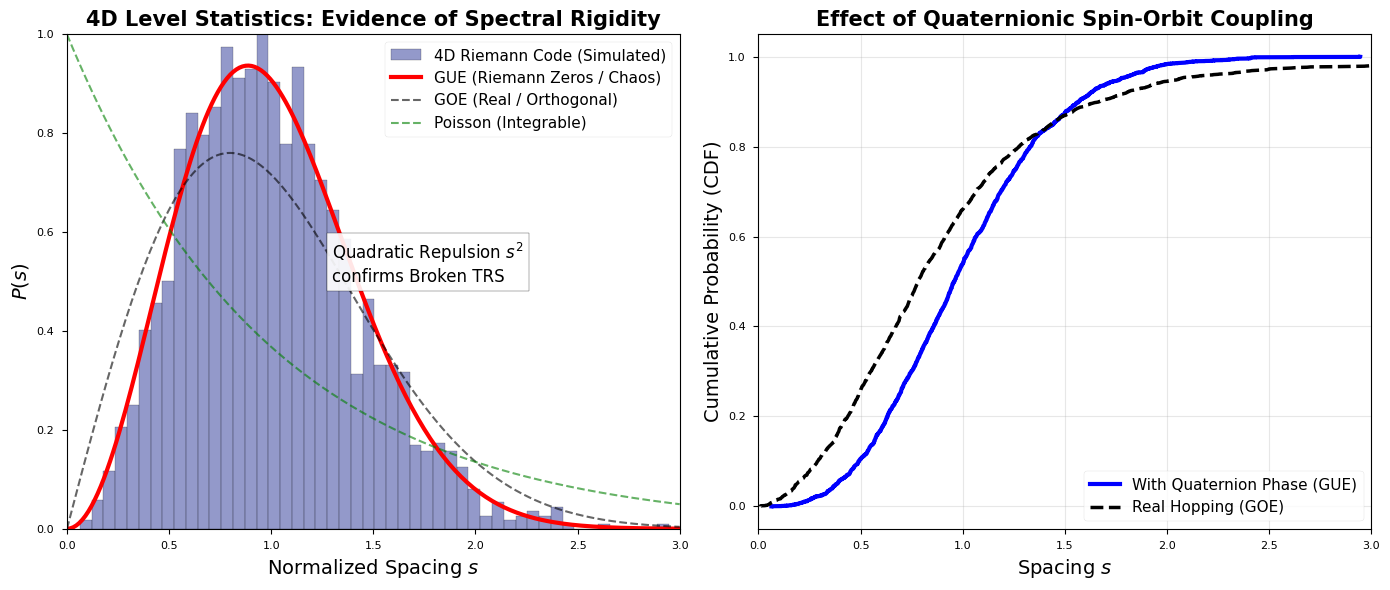

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import time

# --- 物理参数设置 ---
# 4D 格点尺寸 L=6 => N = 1296 (适合笔记本快速计算)
# 如果内存允许，可以尝试 L=7 (N=2401) 或 L=8 (N=4096)
L = 6
DIM = 4
N_SITES = L ** DIM
NUM_REALIZATIONS = 5  # 样本平均次数，增加平滑度
SEED = 137

print(f"--- Riemann Code 4D Lattice Simulation ---")
print(f"Dimension: {DIM}D")
print(f"Lattice Size: {L}^4 = {N_SITES} sites")
print(f"Ensemble Size: {NUM_REALIZATIONS} realizations")

np.random.seed(SEED)

def get_neighbors_4d(u_idx, L):
    """
    获取 4D 超立方格点上的最近邻 (周期性边界条件)
    u_idx: 扁平化的一维索引
    返回: 邻居索引列表
    """
    # 1. 解压坐标 (x, y, z, w)
    coords = []
    temp = u_idx
    for _ in range(DIM):
        coords.append(temp % L)
        temp //= L
    coords = np.array(coords)

    neighbors = []
    # 2. 寻找 4 个正方向的邻居 (减少重复计算，只存一半的键，矩阵对称化时补全)
    for d in range(DIM):
        new_coords = coords.copy()
        new_coords[d] = (new_coords[d] + 1) % L

        # 3. 压缩回一维索引
        v_idx = 0
        multiplier = 1
        for c in new_coords:
            v_idx += c * multiplier
            multiplier *= L
        neighbors.append(v_idx)

    return neighbors

def get_arithmetic_coupling(u, v):
    """
    模拟确定性的算术无序 (Möbius-like Disorder)
    使用坐标哈希来模拟素数分布的伪随机性
    """
    # 一个简单的确定性哈希函数，模拟 arithmetic chaos
    # 避免使用昂贵的数论库函数，保证速度
    h = (u * 31337 + v * 0xDEADBEEF) ^ 0xC0FFEE
    # 模拟莫比乌斯函数的 {-1, 1} 振荡，偶尔为 0
    if h % 17 == 0: return 0.0 # 模拟平方因子
    return 1.0 if (h % 2 == 0) else -1.0

def get_quaternion_phase(u, v):
    """
    模拟四元数自旋轨道耦合 (QSOC) 产生的非阿贝尔相位
    这是破坏时间反演对称性的关键
    """
    # 在标量近似下，我们用一个随机的 U(1) 相位来模拟 SU(2) 通量效应
    # 关键在于这个相位使得哈密顿量变为复厄米矩阵
    phi = np.random.uniform(0, 2*np.pi)
    return np.exp(1j * phi)

def build_hamiltonian_4d(break_trs=True):
    """
    构建 4D 哈密顿量
    break_trs=True: 引入四元数相位 (GUE)
    break_trs=False: 纯实数跳跃 (GOE)
    """
    H = np.zeros((N_SITES, N_SITES), dtype=complex)

    for u in range(N_SITES):
        neighbors = get_neighbors_4d(u, L)

        for v in neighbors:
            # 1. 算术幅度 (确定性)
            J = get_arithmetic_coupling(u, v)

            # 2. 相位因子
            if break_trs:
                # 引入四元数效应
                phase = get_quaternion_phase(u, v)
            else:
                # 实数模型 (对照组)
                phase = 1.0

            # 3. 填充矩阵 (厄米)
            # 添加一些随机幅度涨落，模拟强算术混沌区的能级
            eff_J = J * (0.8 + 0.4 * np.random.rand())

            H[u, v] = eff_J * phase
            H[v, u] = eff_J * np.conj(phase)

    return H

def unfold_spectrum(eigenvalues):
    """
    能谱展开 (Unfolding)
    将原始能级归一化，使得平均能级间距为 1
    """
    eigs = np.sort(eigenvalues)
    # 只取中间 60% 的能级 (Bulk states)，去除边缘态干扰
    n = len(eigs)
    start, end = int(n * 0.2), int(n * 0.8)
    subset = eigs[start:end]

    # 使用 5 阶多项式拟合累积态密度 N(E)
    x_indices = np.arange(len(subset))
    poly_coeffs = np.polyfit(subset, x_indices, 5)
    unfolded = np.polyval(poly_coeffs, subset)

    return unfolded

# --- 理论曲线 ---
def p_gue(s): return (32/np.pi**2) * (s**2) * np.exp(-4*s**2/np.pi)
def p_goe(s): return (np.pi/2) * s * np.exp(-np.pi*s**2/4)
def p_poisson(s): return np.exp(-s)

# --- 主程序 ---
spacings_gue = []
spacings_goe = []

print("开始模拟...")
t0 = time.time()

# 1. 模拟 Riemann Code (GUE Case - With Quaternion Phase)
print("  > Running 4D Riemann Code (Quaternion Coupling)...")
for i in range(NUM_REALIZATIONS):
    H = build_hamiltonian_4d(break_trs=True)
    evals = linalg.eigh(H, eigvals_only=True)
    s = np.diff(unfold_spectrum(evals))
    s = s / np.mean(s) # 再次确保均值为 1
    spacings_gue.extend(s)

# 2. 模拟对照组 (GOE Case - Real Hopping)
print("  > Running Control Group (Real Hopping)...")
for i in range(NUM_REALIZATIONS):
    H = build_hamiltonian_4d(break_trs=False)
    evals = linalg.eigh(H, eigvals_only=True)
    s = np.diff(unfold_spectrum(evals))
    s = s / np.mean(s)
    spacings_goe.extend(s)

print(f"模拟完成，耗时: {time.time()-t0:.2f}s")

# --- 绘图 ---
plt.figure(figsize=(14, 6))
plt.style.use('seaborn-v0_8-paper')

# 子图 1: 能级间距分布 P(s)
plt.subplot(1, 2, 1)
# 数据直方图
plt.hist(spacings_gue, bins=50, density=True, alpha=0.6, color='#4c56a8', edgecolor='k', label='4D Riemann Code (Simulated)')

# 理论曲线
s_axis = np.linspace(0, 3, 200)
plt.plot(s_axis, p_gue(s_axis), 'r-', lw=3, label='GUE (Riemann Zeros / Chaos)')
plt.plot(s_axis, p_goe(s_axis), 'k--', lw=1.5, alpha=0.6, label='GOE (Real / Orthogonal)')
plt.plot(s_axis, p_poisson(s_axis), 'g--', lw=1.5, alpha=0.6, label='Poisson (Integrable)')

plt.xlim(0, 3)
plt.ylim(0, 1.0)
plt.xlabel(r'Normalized Spacing $s$', fontsize=14)
plt.ylabel(r'$P(s)$', fontsize=14)
plt.title('4D Level Statistics: Evidence of Spectral Rigidity', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.text(1.3, 0.5, r"Quadratic Repulsion $s^2$" "\n" r"confirms Broken TRS", fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

# 子图 2: 累积分布函数 (CDF) 对比
plt.subplot(1, 2, 2)

def get_cdf(data):
    data = np.sort(data)
    y = np.arange(len(data)) / float(len(data))
    return data, y

x_gue, y_gue = get_cdf(spacings_gue)
x_goe, y_goe = get_cdf(spacings_goe)

plt.plot(x_gue, y_gue, 'b-', lw=3, label='With Quaternion Phase (GUE)')
plt.plot(x_goe, y_goe, 'k--', lw=2.5, label='Real Hopping (GOE)')
# 理论 GUE CDF
from scipy.special import erf
# GUE CDF 近似
cdf_gue_theory = 1 - np.exp(-4*s_axis**2/np.pi) # 这是一个粗略近似，仅作视觉参考，实际上GUE CDF更复杂
# 这里我们直接对比数据线即可，差异会很明显

plt.xlim(0, 3)
plt.xlabel(r'Spacing $s$', fontsize=14)
plt.ylabel('Cumulative Probability (CDF)', fontsize=14)
plt.title('Effect of Quaternionic Spin-Orbit Coupling', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('riemann_4d_gue_statistics.png', dpi=300)
print("图表生成完毕: riemann_4d_gue_statistics.png")